In [1]:
# import pandas as pd

# # df_ = pd.read_excel("Total.xlsx", index_col=None)

# df = pd.ExcelFile("Total.xlsx")
# print(df.sheet_names)
# df1 = pd.read_excel(df, '1st')
# df2 = pd.read_excel(df, '2nd')
# df3 = pd.read_excel(df, '3rd')
# df_ = pd.concat([df1,df2,df3],axis=0)

# cluster = df_['Cluster'].str.split(' ', n=1, expand=True)
# cluster = cluster.rename(columns={0:'cluster', 1:'kPa'})
# features = df_.drop('Cluster', axis=1)

# df_ = pd.concat([features, cluster], axis=1)
# df_.reset_index(drop=True, inplace=True)
# df_.to_csv('Total.csv', index=False)
# print(df_)

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)

df = pd.read_csv('Total.csv', index_col = None)
columns_new = dict([(name, name.replace('.','__')) for name in df.columns])
df.rename(columns=columns_new, inplace=True)


print(df['kPa'].unique())
kPa = '22kPa'
df_ = df[df['kPa']==kPa]
X = df_.drop(["ID", "cluster","kPa"], axis=1) # Independent variables
# X = X.iloc[:,feature_selected]
y_ = df_.cluster # Dependent variable

y = np.zeros(y_.shape)
y[y_=='TIF'] = 1
y = pd.DataFrame(y, columns=['cluster'], dtype=float)
# y_.loc[y_=='CAF'] = 0
# y_.loc[y_=='TIF'] = 1
# y = y_.astype(float)


X_columns_new = dict([(name, f'ind_{i}_'+name) for i,name in enumerate(X.columns)])
X.rename(columns=X_columns_new, inplace=True)
features = np.array(X.columns)

# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

['1kPa' '4kPa' '6kPa' '22kPa' '60kPa' '0.5kPa']


In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train.iloc[:,:] = scaler.transform(X_train)
X_test.iloc[:,:] = scaler.transform(X_test)

X_train.shape

(272, 149)

In [49]:
unique = np.arange(X_train.shape[1])

In [50]:
from model import get_importance_index

scoring = 'roc_auc'
ranked_idx, importance_score = get_importance_index(X_train.iloc[:,unique], y_train, \
                                                    X_test.iloc[:,unique], y_test, scoring)

{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
Random Forest: 
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88        64
         1.0       0.86      0.83      0.85        53

    accuracy                           0.86       117
   macro avg       0.86      0.86      0.86       117
weighted avg       0.86      0.86      0.86       117

{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}
Logistic regression: 
              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87        64
         1.0       0.81      0.91      0.86        53

    accuracy                           0.86       117
   macro avg       0.86      0.87      0.86       117
weighted avg       0.87      0.86      0.86       117



The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 2, 'colsample_bytree': 1.0}
XGBoost: 
              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88        64
         1.0       0.84      0.89      0.86        53

    accuracy                           0.87       117
   macro avg       0.87      0.87      0.87       117
weighted avg       0.87      0.87      0.87       117



In [17]:
# percent = importance_score/importance_score.sum(0)

# percent.sort(axis=0)
# # plt.plot(percent[::-1,2])
# # print(np.cumsum(percent, axis=0))
# plt.plot(np.cumsum(percent[::-1],axis=0))

In [85]:
unique = []
for i in ranked_idx.flatten():
    if i not in unique:
        unique.append(i)
print(unique)

[11, 1, 18, 19, 15, 4, 17, 5, 2, 24, 10, 6, 3, 20, 12, 13, 16, 0, 23, 7, 21, 26, 9, 14, 25, 22, 8]


In [86]:
# selected_idx = ranked_idx[:40]
# # print(selected_idx)
# unique, count = np.unique(selected_idx, return_counts=True)
# print(unique.shape, count)

In [87]:
selected = X.iloc[:, unique]
# group

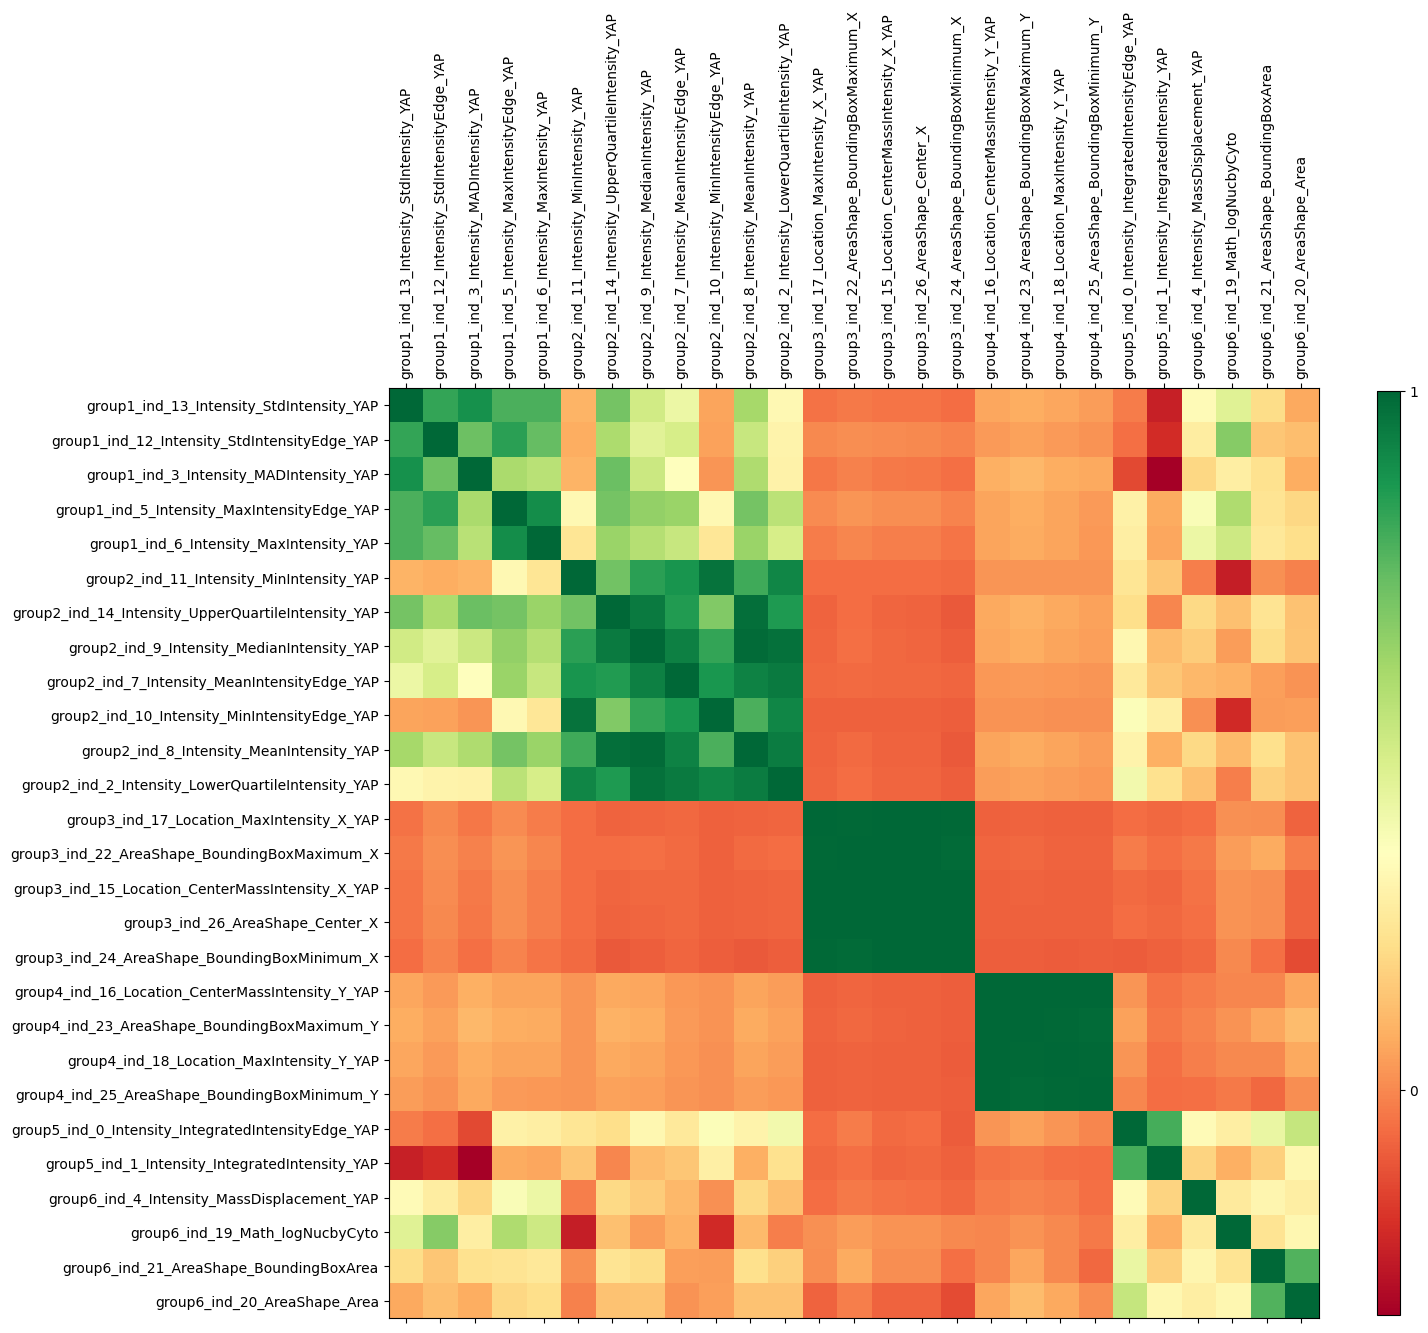

In [88]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

# plot_corr(selected)

import scipy
import scipy.cluster.hierarchy as sch

corr_values = selected.corr().values
d = sch.distance.pdist(corr_values)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [selected.columns.tolist()[i] for i in list((np.argsort(ind)))]
selected_sorted = selected.reindex(columns, axis=1)

selected_columns_new = dict([(name, f'group{i}_'+name) for i,name in zip(np.sort(ind),selected_sorted.columns)])
selected_sorted.rename(columns=selected_columns_new, inplace=True)

plot_corr(selected_sorted, size=15)

In [78]:
group_dict = dict([(i,j) for i, j in zip(unique,ind)])
# group_dict

In [79]:
# print(selected_idx)

group_dict = dict([(i,j) for i, j in zip(unique,ind)])

group = np.zeros_like(ranked_idx).flatten()
for i in range(group.shape[0]):
    group[i] = group_dict.get(ranked_idx.flatten()[i])

group = group.reshape(ranked_idx.shape)

# [selected_idx[group==i] for i in range(1,np.unique(ind).shape[0]+1)]

for i in range(1,np.unique(ind).shape[0]+1):
    group_member = ranked_idx[group==i]
    group_member_clean = []
    for mem in group_member:
        if mem not in group_member_clean:
            group_member_clean.append(mem)
    print(group_member_clean)


[24, 15, 26, 17, 22]
[18, 16, 25, 27, 23]
[33, 32, 41]
[1, 0]
[36, 20, 31, 39, 38, 40, 35, 34, 29, 21, 37]
[9, 7, 2, 10, 14, 11, 8]
[30, 28]
[6, 5, 19, 3, 4, 13, 12]


In [80]:
for re in [40, 35, 34, 29, 21, 37,4, 13, 12, 17, 22,27, 23,14, 11, 8]:
    index = np.argwhere(unique==re)
    unique = np.delete(unique, index)

In [84]:
unique.shape

(27,)

In [82]:
from model import get_importance_index

scoring = 'roc_auc'
ranked_idx, importance_score = get_importance_index(X_train.iloc[:,unique], y_train, \
                                                    X_test.iloc[:,unique], y_test, scoring)

{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest: 
              precision    recall  f1-score   support

         0.0       0.82      0.94      0.88        64
         1.0       0.91      0.75      0.82        53

    accuracy                           0.85       117
   macro avg       0.87      0.85      0.85       117
weighted avg       0.86      0.85      0.85       117



/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.001}
Logistic regression: 
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83        64
         1.0       0.79      0.79      0.79        53

    accuracy                           0.81       117
   macro avg       0.81      0.81      0.81       117
weighted avg       0.81      0.81      0.81       117



/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
XGBoost: 
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88        64
         1.0       0.87      0.85      0.86        53

    accuracy                           0.87       117
   macro avg       0.87      0.87      0.87       117
weighted avg       0.87      0.87      0.87       117



In [83]:
selected_sorted.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
selected_y = pd.concat([selected_sorted,y], axis=1)


## get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

status_name = 'cluster'
anova_list = list(selected_sorted.columns)
    
pvalue = {}
pvalue_problem = {}
for cov in anova_list:
    # Ordinary Least Squares (OLS) model
    model = ols(f'{status_name} ~ {cov}', data=selected_y).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    _pvalue = anova_table['PR(>F)'][cov]
    pvalue[cov] = _pvalue

    if _pvalue>.05:
        print(f'{cov}: {_pvalue}')
        pvalue_problem[cov] = _pvalue
        
# print(pvalue_problem)

group1_ind_24_AreaShape_BoundingBoxMinimum_X: 0.6288783454904154
group1_ind_15_Location_CenterMassIntensity_X_YAP: 0.6013661488068496
group1_ind_26_AreaShape_Center_X: 0.6517301932538547
group1_ind_22_AreaShape_BoundingBoxMaximum_X: 0.7230166443209263
group1_ind_17_Location_MaxIntensity_X_YAP: 0.5627402005094424
group2_ind_27_AreaShape_Center_Y: 0.9029519466446784
group2_ind_25_AreaShape_BoundingBoxMinimum_Y: 0.8654852822679809
group2_ind_16_Location_CenterMassIntensity_Y_YAP: 0.9110726083374896
group2_ind_18_Location_MaxIntensity_Y_YAP: 0.9850122147640248
group2_ind_23_AreaShape_BoundingBoxMaximum_Y: 0.9678055183824258
group3_ind_41_AreaShape_Orientation: 0.4029020738118808
group3_ind_32_AreaShape_Extent: 0.30707805814917766
group4_ind_0_Intensity_IntegratedIntensityEdge_YAP: 0.10595928777533496
group4_ind_1_Intensity_IntegratedIntensity_YAP: 0.8707522202509788
group5_ind_34_AreaShape_MajorAxisLength: 0.06452752946148636
group5_ind_21_AreaShape_BoundingBoxArea: 0.1495934034176537
grou